# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import  to_categorical
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

# Funções Auxiliares

In [2]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, f1, 'k', label='Training F1 Score')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.plot(x, val_f1, 'g', label='Validation F1 Score')
    plt.title('Acurácia e F1 Score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Perda')
    plt.legend()
    
class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)
        
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def grupos(lista, subs):
    tam = len(lista)
    res = []
    res_df = pd.DataFrame()
    for i in range(0, tam, subs):
        tmp = lista[i:i+subs]
        if (len(tmp) == subs):
            res.append(tmp.mean())
    return res

# Análise dos Dados

## Carregando os dados

In [3]:
df = pd.read_csv("./data/pulsar_stars.csv", header=0, names=['MIP', 'SDIP', 'EKIP', 'SIP', 'MDM-SNR', 'SDDM-SNR', 'EKDM-SNR', 'SDM-SNR', 'target'])

## Amostra dos Dados

In [5]:
df.head()

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


## Conferindo se temos dados nulos, qual o formato das variáveis e quais podem ser numéricas ou categóricas

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MIP       17898 non-null  float64
 1   SDIP      17898 non-null  float64
 2   EKIP      17898 non-null  float64
 3   SIP       17898 non-null  float64
 4   MDM-SNR   17898 non-null  float64
 5   SDDM-SNR  17898 non-null  float64
 6   EKDM-SNR  17898 non-null  float64
 7   SDM-SNR   17898 non-null  float64
 8   target    17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [6]:
df.isnull().sum()

MIP         0
SDIP        0
EKIP        0
SIP         0
MDM-SNR     0
SDDM-SNR    0
EKDM-SNR    0
SDM-SNR     0
target      0
dtype: int64

## Distribuição das respostas


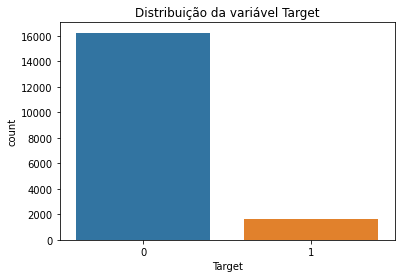

In [8]:
sns.countplot(x = df.target)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks(ticks=range(0,2), labels=['0', '1'])
plt.show()

### Vamos reduzir a respota "0" para ficar compartível com a varíavel 1. Para isso iremos dividir as respostas "0" em +/- 1600 grupos e tirar a média dos mesmos.

In [9]:
c = round(df.groupby('target').count().MIP)
print(f"Quantidades: 0 = {c[0]} e 1 = {c[1]}")
print('-'*50)
subs = math.ceil(c[0]/c[1])
negativas = df[df.target == 0]
negativas = grupos(negativas, subs)
print(negativas[0])
print(f"Quantidade final: 0 = {len(negativas)} e 1 = {c[1]}")

Quantidades: 0 = 16259 e 1 = 1639
--------------------------------------------------
MIP         112.950781
SDIP         47.918933
EKIP          0.241014
SIP           0.235100
MDM-SNR       2.308779
SDDM-SNR     16.581414
EKDM-SNR     10.721943
SDM-SNR     154.611295
target        0.000000
dtype: float64
Quantidade final: 0 = 1625 e 1 = 1639


In [10]:
df_final = pd.DataFrame()
df_final = pd.concat(negativas, ignore_index=True, axis=1).T
df_final

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,112.950781,47.918933,0.241014,0.235100,2.308779,16.581414,10.721943,154.611295,0.0
1,122.826562,49.221999,0.077544,0.017286,4.718562,24.909668,7.806080,81.871273,0.0
2,112.427344,49.117316,0.202946,0.058117,3.173913,19.209042,9.373305,111.543404,0.0
3,121.482812,46.729040,0.098601,0.324605,2.380853,16.975910,10.749121,154.253410,0.0
4,116.225781,48.677019,0.226620,0.109116,2.432358,17.298481,10.144861,127.757623,0.0
...,...,...,...,...,...,...,...,...,...
1620,111.690625,46.934039,0.215711,0.321320,16.111789,34.533356,7.078829,78.093823,0.0
1621,117.635156,49.079374,0.234606,0.107255,4.347492,22.373660,8.792710,98.365991,0.0
1622,114.566406,43.731026,0.276497,1.037177,2.783863,18.012064,11.382899,171.067199,0.0
1623,116.150000,47.684957,0.212700,0.291412,3.907023,20.858949,9.947946,137.493596,0.0


In [11]:
positivas = df[df.target == 1]
df_final = pd.concat([df_final, positivas])
df_final

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,112.950781,47.918933,0.241014,0.235100,2.308779,16.581414,10.721943,154.611295,0.0
1,122.826562,49.221999,0.077544,0.017286,4.718562,24.909668,7.806080,81.871273,0.0
2,112.427344,49.117316,0.202946,0.058117,3.173913,19.209042,9.373305,111.543404,0.0
3,121.482812,46.729040,0.098601,0.324605,2.380853,16.975910,10.749121,154.253410,0.0
4,116.225781,48.677019,0.226620,0.109116,2.432358,17.298481,10.144861,127.757623,0.0
...,...,...,...,...,...,...,...,...,...
17515,89.867188,47.482295,1.591325,2.505057,0.763378,12.393561,17.940745,333.902630,1.0
17529,27.039062,33.754722,4.779124,26.255357,129.863712,78.815440,-0.348492,-0.893791,1.0
17558,77.070312,39.000638,1.884421,6.372178,38.517559,65.741059,1.589513,1.285346,1.0
17642,28.375000,27.649311,6.377273,45.944048,141.860368,82.893017,-0.477222,-1.067880,1.0


C:\Users\hgf77\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


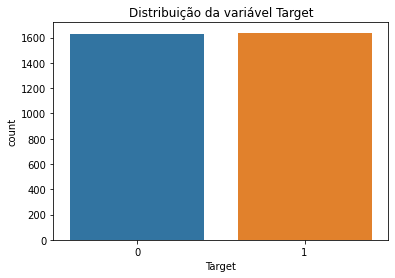

In [13]:
sns.countplot(df_final.target)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks(ticks=range(0,2), labels=['0', '1'])
plt.show()

## Análise de correlação

<AxesSubplot:>

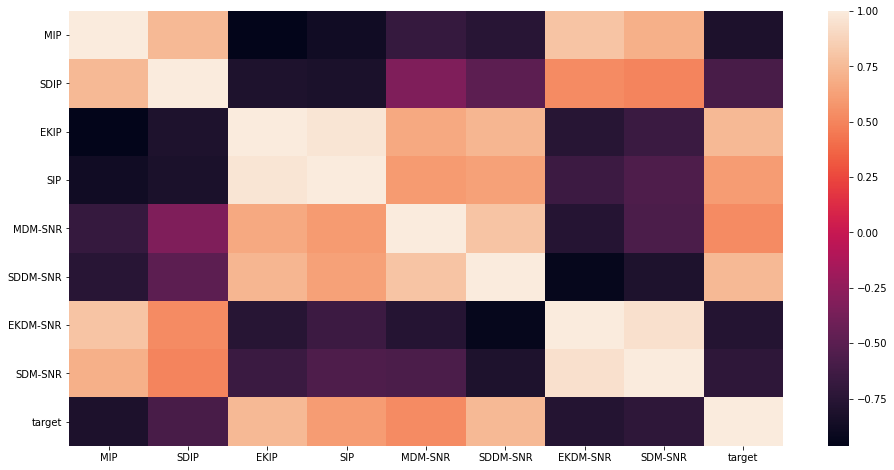

In [14]:
fig = plt.figure(figsize=(16,8))
sns.heatmap(df_final.corr())

In [15]:
X = df_final.iloc[:,0:8].to_numpy()
X[:2]

array([[1.12950781e+02, 4.79189331e+01, 2.41013884e-01, 2.35099994e-01,
        2.30877926e+00, 1.65814140e+01, 1.07219431e+01, 1.54611295e+02],
       [1.22826562e+02, 4.92219992e+01, 7.75444434e-02, 1.72862243e-02,
        4.71856187e+00, 2.49096679e+01, 7.80608041e+00, 8.18712730e+01]])

In [16]:
y = df_final.target.to_numpy()
y[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Padronizando os dados com o StandardScaler do SKlearn. 
### Dados finais com média 0 e variância igual ao desvio padrão

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X[:5])

[[ 0.716266    0.67376385 -0.72724048 -0.62183544 -0.70017257 -1.04401482
   1.2475344   1.35014504]
 [ 0.98368118  0.85240386 -0.81003907 -0.63927886 -0.63795524 -0.67191491
   0.50902702  0.24756328]
 [ 0.70209243  0.83805269 -0.74652198 -0.63600898 -0.67783599 -0.92661444
   0.90596161  0.69732875]
 [ 0.94729528  0.51063891 -0.79937364 -0.61466747 -0.69831173 -1.02638906
   1.25441777  1.34472028]
 [ 0.80494604  0.77769135 -0.73453113 -0.63192477 -0.69698194 -1.01197682
   1.10137544  0.94310133]]


In [18]:
num_features = X.shape[1]
X.shape

(3264, 8)

In [19]:
y.shape

(3264,)

## Dividindo a Base de Dados entre 80% Treino e 20% Teste.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.shape

(2611, 8)

In [22]:
y_train.shape

(2611,)

# Modelo de MLP

## Criando o modelo

In [23]:
model = Sequential()
model.add(Dense(16, input_dim=num_features, activation='relu'))
model.add(Dense(1 , activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
None


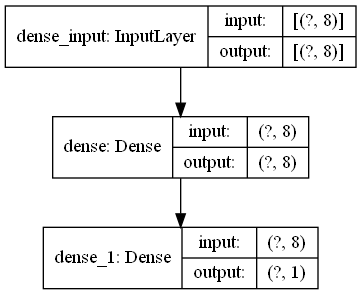

In [37]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Compilando e treinando o modelo. 
### Vamos utilizar a função de Callback ModelCheckPointer para salvar o modelo com a melhor accuracia na base de validação (que é a mesma de teste final pois temos uma base muito pequena)

In [25]:
%%time
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', get_f1])

checkpointer = ModelCheckpoint_tweaked(filepath='./modelo_mlp_ex3_3.hdf5', verbose=1,  mode='max', save_best_only=True, monitor='val_get_f1')

#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[checkpointer])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=1, callbacks=[checkpointer])

Epoch 1/100
125/131 [===========================>..] - ETA: 0s - loss: 0.4173 - accuracy: 0.8185 - get_f1: 0.8214
Epoch 00001: val_get_f1 improved from -inf to 0.88005, saving model to .\modelo_mlp_ex3_3.hdf5
131/131 [==============================] - 1s 4ms/step - loss: 0.4144 - accuracy: 0.8238 - get_f1: 0.8268 - val_loss: 0.2948 - val_accuracy: 0.8910 - val_get_f1: 0.8800
Epoch 2/100
112/131 [========================>.....] - ETA: 0s - loss: 0.2528 - accuracy: 0.9196 - get_f1: 0.9094
Epoch 00002: val_get_f1 improved from 0.88005 to 0.89922, saving model to .\modelo_mlp_ex3_3.hdf5
131/131 [==============================] - 0s 3ms/step - loss: 0.2494 - accuracy: 0.9200 - get_f1: 0.9086 - val_loss: 0.2444 - val_accuracy: 0.9082 - val_get_f1: 0.8992
Epoch 3/100
124/131 [===========================>..] - ETA: 0s - loss: 0.2086 - accuracy: 0.9315 - get_f1: 0.9269
Epoch 00003: val_get_f1 improved from 0.89922 to 0.91064, saving model to .\modelo_mlp_ex3_3.hdf5
131/131 [====================

## Gráfico comparativo da Acurácia , F1 Score e Perda no treinamento

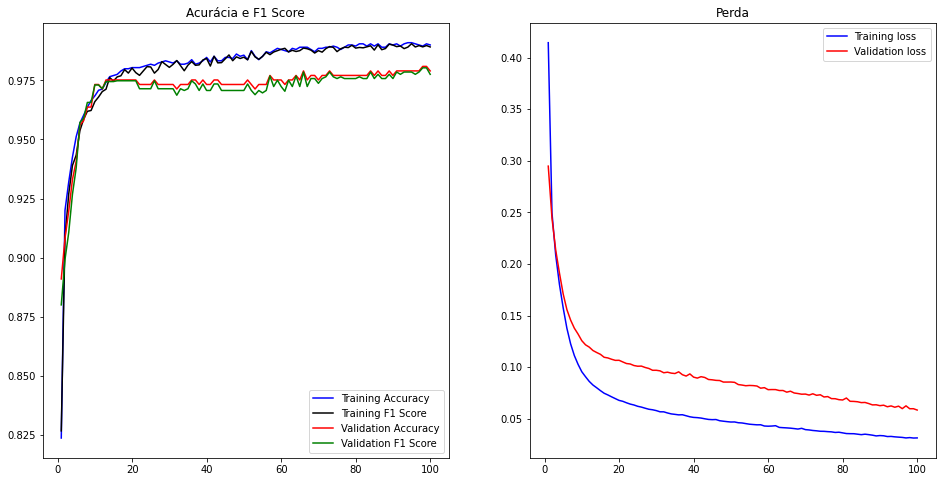

In [26]:
plot_history(history)

## Apresentando a Acurácia e F1 Score final do Treino, carregando o melhor modelo salvo e apresentando a Acurácia e F1 Score do Teste

In [27]:
scores = model.evaluate(X_train, y_train)
print()
print(f"Acurácia do Treino: {round(scores[1]*100,2)}%")
print(f"F1 Score do Treino: {round(scores[2]*100,2)}%")

82/82 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9885 - get_f1: 0.9881

Acurácia do Treino: 98.85%
F1 Score do Treino: 98.81%


In [28]:
model = load_model("./modelo_mlp_ex3_3.hdf5", custom_objects={'get_f1': get_f1})

In [29]:
scores = model.evaluate(X_test, y_test)
print()
print(f"Acurácia do Teste: {round(scores[1]*100,2)}%")
print(f"F1 Score do Teste: {round(scores[2]*100,2)}%")

21/21 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9877 - get_f1: 0.9872

Acurácia do Teste: 98.77%
F1 Score do Teste: 98.72%
